In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import os
import random
import warnings
warnings.filterwarnings('ignore')
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

2025-09-26 09:36:47.037228: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758879407.205290      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758879407.253206      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


kütüphaneleri import ediyoruz.

# ****KONTROL NOKTASI

Kullanılacak eğitim verisi klasörü: ../input/intel-image-classification/seg_train/seg_train

Başarıyla bulunan sınıflar: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']



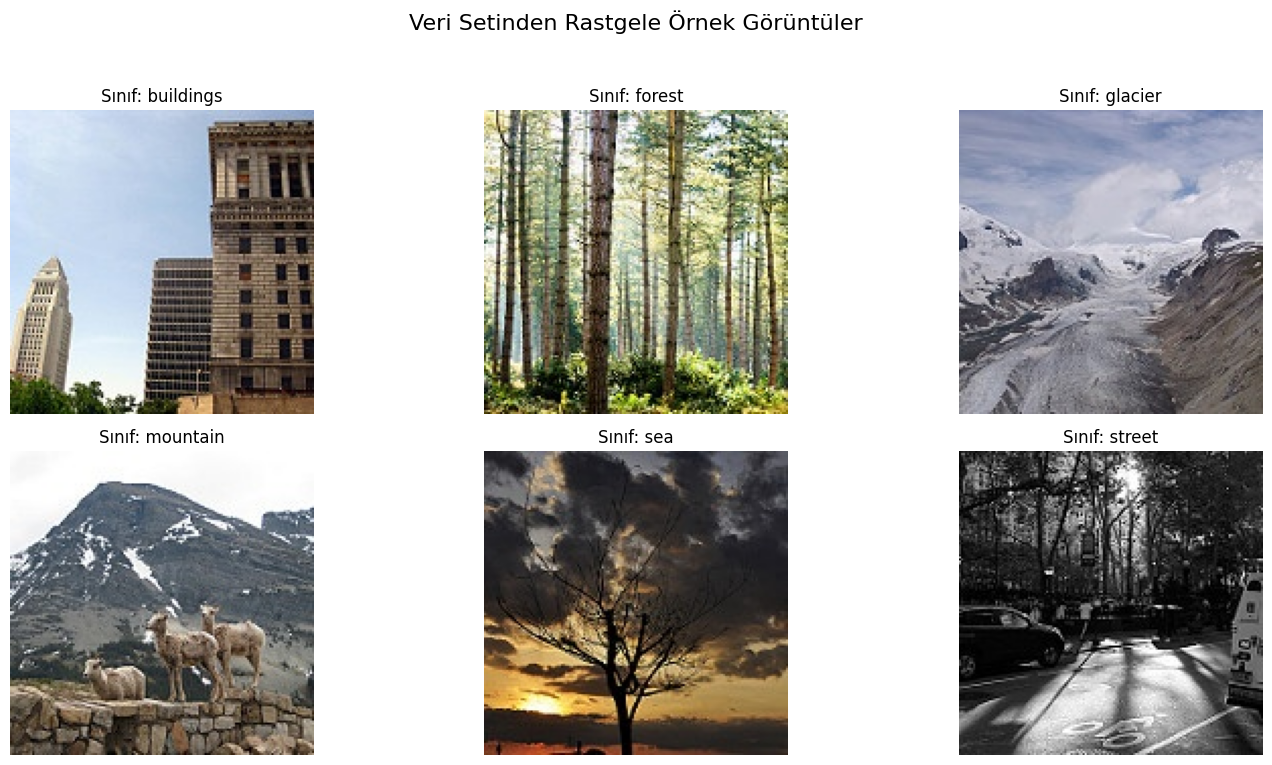

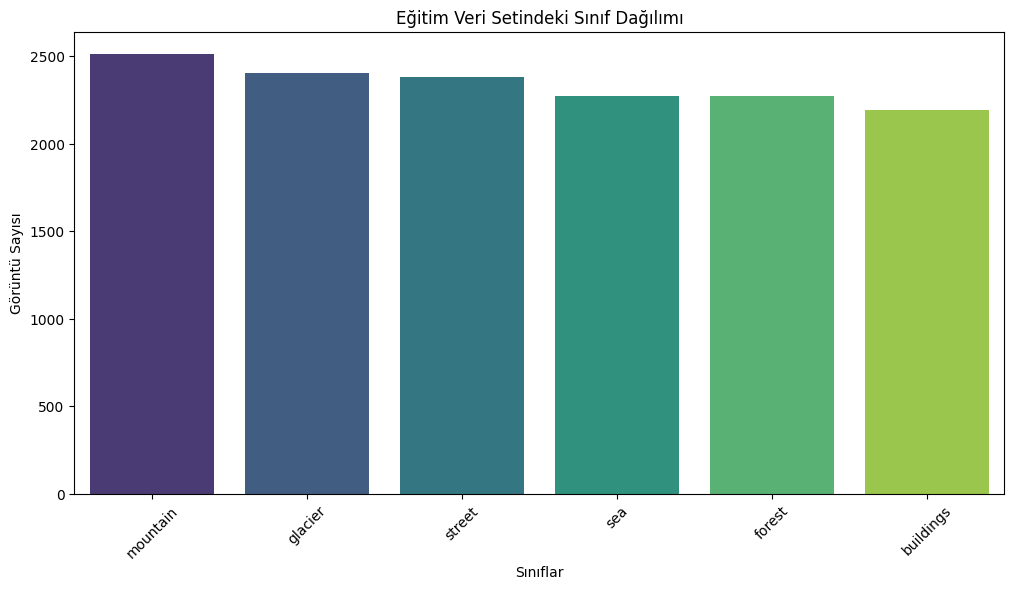


(EDA) adımı başarıyla tamamlandı.
       Sınıf  Görüntü Sayısı
0   mountain            2512
1    glacier            2404
2     street            2382
3        sea            2274
4     forest            2271
5  buildings            2191


In [2]:
train_dir = '../input/intel-image-classification/seg_train/seg_train'

print(f"Kullanılacak eğitim verisi klasörü: {train_dir}\n")

try:
    class_names = sorted(os.listdir(train_dir))
    print(f"Başarıyla bulunan sınıflar: {class_names}\n")
except FileNotFoundError:
    print(f"HATA: '{train_dir}' yolu bulunamadı.")
    class_names = []

if class_names:
    plt.figure(figsize=(15, 8))
    for i, class_name in enumerate(class_names):
        class_path = os.path.join(train_dir, class_name)
        all_images = os.listdir(class_path)
        random_image = random.choice(all_images)
        image_path = os.path.join(class_path, random_image)
        
        plt.subplot(2, 3, i + 1)
        img = plt.imread(image_path)
        plt.imshow(img)
        plt.title(f'Sınıf: {class_name}')
        plt.axis('off')

    plt.suptitle('Veri Setinden Rastgele Örnek Görüntüler', fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    image_counts = []
    for class_name in class_names:
        class_path = os.path.join(train_dir, class_name)
        count = len(os.listdir(class_path))
        image_counts.append((class_name, count))

    df_counts = pd.DataFrame(image_counts, columns=['Sınıf', 'Görüntü Sayısı'])

    df_counts_sorted = df_counts.sort_values(by='Görüntü Sayısı', ascending=False)

    plt.figure(figsize=(12, 6))
    sns.barplot(x='Sınıf', y='Görüntü Sayısı', data=df_counts_sorted, palette='viridis')

    plt.title('Eğitim Veri Setindeki Sınıf Dağılımı')
    plt.xlabel('Sınıflar')
    plt.ylabel('Görüntü Sayısı')
    plt.xticks(rotation=45)
    plt.show()
    
    print("\n(EDA) adımı başarıyla tamamlandı.")
    print(df_counts_sorted.reset_index(drop=True))

## 2. Adım: Veri Keşfi ve Analizi (Exploratory Data Analysis - EDA)

Bu bölümde, modelimizi eğitmeden önce üzerinde çalışacağımız veri setini daha yakından tanıyacağız. Verinin yapısını anlamak, sınıfların dağılımını görmek ve olası sorunları erkenden tespit etmek, başarılı bir model kurmanın ilk adımıdır.

### 2.1. Sınıf Örneklerini Görselleştirme

Aşağıdaki kod hücresi, veri setimizdeki 6 farklı sınıftan (`buildings`, `forest`, `glacier`, `mountain`, `sea`, `street`) rastgele birer örnek görüntü seçecek ve ekrana çizecektir. Bu sayede her bir sınıfın ne tür görseller içerdiğini ve modelimizin ne tür desenleri öğrenmesi gerektiğini daha iyi anlayabiliriz.

### 2.2. Sınıf Dağılımını Analiz Etme

Modelin herhangi bir sınıfa karşı yanlı (biased) öğrenmesini engellemek için eğitim verisindeki sınıfların dağılımını kontrol etmek kritik öneme sahiptir. Şimdi, her sınıfta kaç adet görüntü olduğunu sayacak ve bu dağılımı bir bar grafiği ile görselleştireceğiz. Bu analiz, veri setimizde bir sınıfın diğerlerine göre çok daha fazla veya az sayıda olup olmadığını görmemizi sağlayacaktır.

---

#### EDA Sonucu ve Yorumu

Grafik incelendiğinde, sınıflar arasında veri adedi bakımından büyük bir dengesizlik olmadığı görülmektedir. Sınıflar yaklaşık olarak 2200 ile 2500 arasında görüntü içermektedir. Bu dengeli dağılım, modelin eğitimi için sağlıklı bir başlangıç noktası sunmaktadır ve herhangi bir sınıfa karşı özel bir önlem (örneğin, ağırlıklandırma) almamıza gerek olmadığını göstermektedir.

# IMAGE DATA GENERATOR NOKTASI****

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


IMG_HEIGHT = 150
IMG_WIDTH = 150
BATCH_SIZE = 32


train_dir = '../input/intel-image-classification/seg_train/seg_train'
test_dir = '../input/intel-image-classification/seg_test/seg_test' 

print(f"Eğitim yolu: {train_dir}")
print(f"Test yolu: {test_dir}")

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse', 
    shuffle=True
)

validation_generator = validation_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    shuffle=False
)

Eğitim yolu: ../input/intel-image-classification/seg_train/seg_train
Test yolu: ../input/intel-image-classification/seg_test/seg_test
Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## 3. Adım: Veri Hazırlama ve Çoğaltma (Data Augmentation)

Bu bölümde, diskteki görüntü dosyalarını modelimizin anlayabileceği bir formata getirecek ve eğitim setini zenginleştirecek olan `ImageDataGenerator`'ları hazırlıyoruz. Bu işlem, modelin performansını artırmak ve ezberlemesini (overfitting) önlemek için kritik öneme sahiptir.

### 3.1. Eğitim Verisi için Veri Çoğaltma

Eğitim verileri için, görüntüleri sadece normalize etmekle kalmayıp aynı zamanda çeşitli rastgele dönüşümler uygulayarak veri setimizi yapay olarak zenginleştiriyoruz. Aşağıdaki kod, her bir epoch'ta modele aynı görüntünün biraz değiştirilmiş farklı versiyonlarını sunar. Bu, modelin daha sağlam ve genelleştirilebilir özellikler öğrenmesini sağlar.

Uygulanan dönüşümler:
* **`rescale=1./255`**: Piksel değerlerini 0-255 aralığından 0-1 aralığına indirger.
* **`rotation_range`**: Görüntüyü rastgele döndürür.
* **`width/height_shift_range`**: Görüntüyü yatay ve dikeyde rastgele kaydırır.
* **`zoom_range`**: Görüntüye rastgele yakınlaştırma uygular.
* **`horizontal_flip`**: Görüntüyü rastgele yatay olarak çevirir.

### 3.2. Doğrulama (Validation) Verisi

Doğrulama seti için herhangi bir veri çoğaltma işlemi **uygulamıyoruz.** Modelin gerçek dünya performansını, değiştirilmemiş ve orijinal görüntüler üzerinde ölçmek istediğimiz için bu sette sadece piksel değerlerini 0-1 aralığına getiren `rescale` işlemi yapılır.

Yukarıdaki kod, bu iki ayrı veri hazırlama akışını (`train_generator` ve `validation_generator`) oluşturur.

In [5]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping 

model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.6),
    Dense(6, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_generator, 
    epochs=50, 
    validation_data=validation_generator,
    callbacks=[early_stopping] 
)


model.save("akbank_model_son.keras")
print("Model working klasörüne kaydedildi.")

I0000 00:00:1758879888.309127      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Epoch 1/50


I0000 00:00:1758879893.059122     128 service.cc:148] XLA service 0x7874580071c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758879893.059930     128 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1758879893.370496     128 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/439 ━━━━━━━━━━━━━━━━━━━━ 46:20 6s/step - accuracy: 0.1562 - loss: 1.8241

I0000 00:00:1758879896.603348     128 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


439/439 ━━━━━━━━━━━━━━━━━━━━ 137s 297ms/step - accuracy: 0.4804 - loss: 1.2845 - val_accuracy: 0.6640 - val_loss: 0.8570
Epoch 2/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 86s 197ms/step - accuracy: 0.6533 - loss: 0.9167 - val_accuracy: 0.7593 - val_loss: 0.6599
Epoch 3/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 86s 196ms/step - accuracy: 0.6971 - loss: 0.7978 - val_accuracy: 0.7830 - val_loss: 0.5795
Epoch 4/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 86s 195ms/step - accuracy: 0.7327 - loss: 0.7188 - val_accuracy: 0.7707 - val_loss: 0.6428
Epoch 5/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 85s 193ms/step - accuracy: 0.7384 - loss: 0.6936 - val_accuracy: 0.8203 - val_loss: 0.5138
Epoch 6/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 85s 193ms/step - accuracy: 0.7626 - loss: 0.6469 - val_accuracy: 0.8240 - val_loss: 0.5027
Epoch 7/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 85s 195ms/step - accuracy: 0.7801 - loss: 0.6114 - val_accuracy: 0.8237 - val_loss: 0.4911
Epoch 8/50
439/439 ━━━━━━━━━━━━━━━━━━━━ 86s 195ms/step - accuracy: 0.7763 - loss: 0.6090 - va

## 4. Adım: Modelin Oluşturulması ve Eğitilmesi

Bu aşamada, projenin temelini oluşturan Evrişimli Sinir Ağı (CNN) modelini tasarlayacak, derleyecek ve hazırladığımız verilerle eğiteceğiz.

### 4.1. Model Mimarisi

Proje için standart ve etkili bir CNN mimarisi oluşturulmuştur. Model, üç ana konvolüsyon bloğundan oluşur. Her blok, bir `Conv2D` katmanı ile özellik haritaları çıkarır ve bir `MaxPooling2D` katmanı ile bu haritaları özetleyerek boyutunu küçültür. Katmanlar derinleştikçe filtre sayısı artırılarak (32 -> 64 -> 128) modelin daha karmaşık desenleri öğrenmesi hedeflenmiştir.

Konvolüsyon bloklarından sonra, `Flatten` katmanı ile özellikler tek boyutlu bir vektöre dönüştürülür ve `Dense` katmanları ile sınıflandırma işlemi gerçekleştirilir. Aşırı öğrenmeyi (overfitting) kontrol altında tutmak amacıyla `Dropout(0.6)` katmanı eklenmiştir. Son katman ise 6 sınıfa ait olasılıkları hesaplayan `softmax` aktivasyon fonksiyonuna sahip bir `Dense` katmanıdır.

### 4.2. Modelin Derlenmesi ve Eğitim Süreci

Model, `adam` optimizer'ı ve `sparse_categorical_crossentropy` kayıp fonksiyonu ile derlenmiştir. Eğitim süresince modelin başarısını izlemek için `accuracy` metriği kullanılmıştır.

#### Erken Durdurma (Early Stopping)
Modelin gereğinden fazla eğitilerek ezber yapmasını (overfitting) önlemek ve en optimum noktada eğitimi sonlandırmak için **`EarlyStopping`** tekniği kullanılmıştır. Bu teknik, doğrulama setindeki kaybı (`val_loss`) izler ve 5 epoch boyunca bir iyileşme görmediğinde eğitimi otomatik olarak durdurur. `restore_best_weights=True` parametresi sayesinde, eğitim durduğunda modelin en iyi performansı gösterdiği andaki ağırlıkları geri yüklenir.

Yukarıdaki kod, bu mimariyi oluşturur, derler ve `EarlyStopping` kontrolünde 50 epoch'a kadar eğitir. Eğitim tamamlandığında, en iyi model `akbank_model_son.keras` adıyla kaydedilir.

Eğitim süreci grafikleri oluşturuluyor...


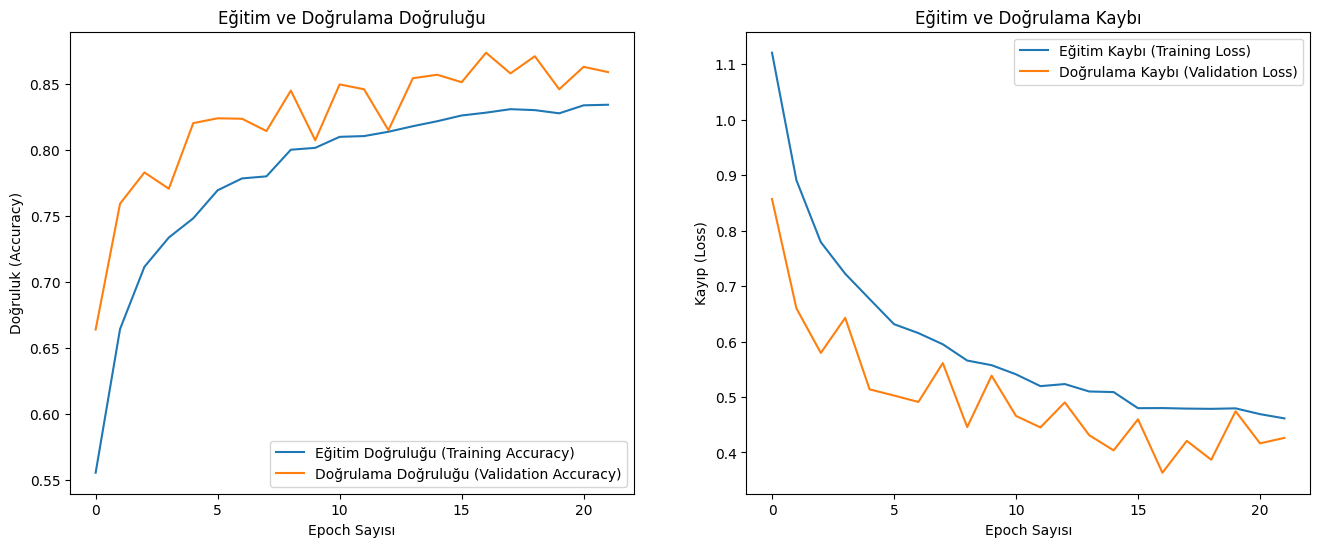

In [6]:
import matplotlib.pyplot as plt


print("Eğitim süreci grafikleri oluşturuluyor...")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

plt.figure(figsize=(16, 6))

# Doğruluk Grafiği
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Eğitim Doğruluğu (Training Accuracy)')
plt.plot(epochs_range, val_acc, label='Doğrulama Doğruluğu (Validation Accuracy)')
plt.legend(loc='lower right')
plt.title('Eğitim ve Doğrulama Doğruluğu')
plt.xlabel('Epoch Sayısı')
plt.ylabel('Doğruluk (Accuracy)')

# Kayıp Grafiği
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Eğitim Kaybı (Training Loss)')
plt.plot(epochs_range, val_loss, label='Doğrulama Kaybı (Validation Loss)')
plt.legend(loc='upper right')
plt.title('Eğitim ve Doğrulama Kaybı')
plt.xlabel('Epoch Sayısı')
plt.ylabel('Kayıp (Loss)')

plt.show()

## 5. Adım: Modelin Değerlendirilmesi ve Sonuçların Yorumlanması

Modelin eğitimi tamamlandıktan sonra, öğrenme sürecinin sağlığını analiz etmek ve modelin nihai performansını değerlendirmek için çeşitli görselleştirmeler ve metrikler kullanılmıştır.

### 5.1. Eğitim ve Doğrulama Grafikleri (Öğrenme Eğrileri)

Aşağıdaki kod, modelin her bir `epoch` (eğitim turu) sonundaki performansını gösteren doğruluk (accuracy) ve kayıp (loss) grafiklerini çizer. Bu grafikler, modelin öğrenme sürecini görsel olarak anlamamız ve aşırı öğrenme (overfitting) gibi potansiyel sorunları tespit etmemiz için kritik öneme sahiptir.

* **Doğruluk Grafiği:** Modelin hem eğitim verisindeki hem de daha önce görmediği doğrulama verisindeki başarısının zamanla nasıl değiştiğini gösterir.
* **Kayıp Grafiği:** Modelin tahminlerindeki hata oranının eğitim süresince nasıl azaldığını gösterir.

Bu grafiklerin analizi, projenin en önemli yorumlama adımlarından biridir.

Kaydedilmiş model 'akbank_model_son.keras' yükleniyor...
Model başarıyla yüklendi.

Model değerlendirme adımı başlıyor...
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step

Karmaşıklık Matrisi (Confusion Matrix)


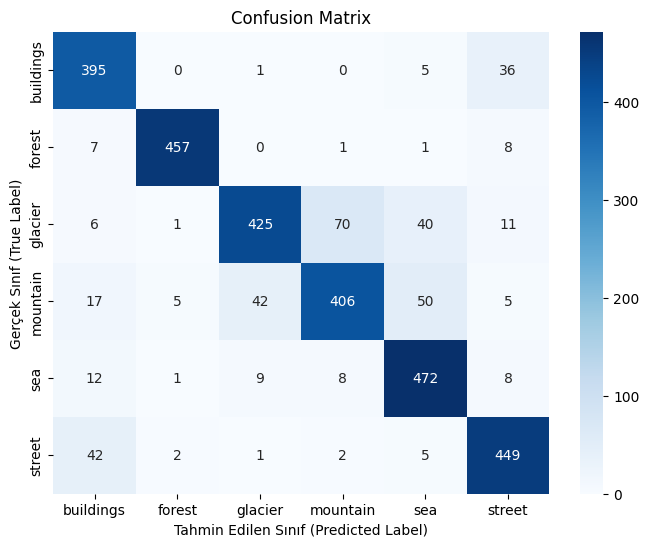


Sınıflar Raporu (Classification Report)
              precision    recall  f1-score   support

   buildings       0.82      0.90      0.86       437
      forest       0.98      0.96      0.97       474
     glacier       0.89      0.77      0.82       553
    mountain       0.83      0.77      0.80       525
         sea       0.82      0.93      0.87       510
      street       0.87      0.90      0.88       501

    accuracy                           0.87      3000
   macro avg       0.87      0.87      0.87      3000
weighted avg       0.87      0.87      0.87      3000



In [7]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

print("Kaydedilmiş model 'akbank_model_son.keras' yükleniyor...")
model = load_model("/kaggle/input/akbank-dataset/akbank_model_son.keras")
print("Model başarıyla yüklendi.")

print("\nModel değerlendirme adımı başlıyor...")

validation_steps = len(validation_generator)
Y_pred = model.predict(validation_generator, steps=validation_steps)
y_pred = np.argmax(Y_pred, axis=1)
y_true = validation_generator.classes
y_true = y_true[:len(y_pred)]

class_labels = list(validation_generator.class_indices.keys())

print('\nKarmaşıklık Matrisi (Confusion Matrix)')
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('Gerçek Sınıf (True Label)')
plt.xlabel('Tahmin Edilen Sınıf (Predicted Label)')
plt.show()

print('\nSınıflar Raporu (Classification Report)')
print(classification_report(y_true, y_pred, target_names=class_labels))

### 5.2. Nihai Model Performansının Değerlendirilmesi

Eğitim sürecini analiz ettikten sonra, kaydettiğimiz en iyi modelin daha önce hiç görmediği test verileri üzerindeki nihai performansını ölçmek için standart değerlendirme metrikleri kullanılmıştır. Bu, modelimizin gerçek dünya başarısını anlamamız için en önemli adımdır.

Aşağıdaki kod, önceden eğitip kaydettiğimiz modeli yükler, test seti üzerinde tahminler yapar ve bu tahminleri gerçek etiketlerle karşılaştırarak **Karmaşıklık Matrisi (Confusion Matrix)** ve **Sınıflandırma Raporu'nu (Classification Report)** oluşturur.

#### Karmaşıklık Matrisi (Confusion Matrix)

Karmaşıklık matrisi, modelin sınıf bazındaki performansını görsel olarak özetler. Matrisin köşegenindeki (sol üstten sağ alta) sayılar, doğru yapılan tahminlerin sayısını gösterir. Köşegen dışındaki sayılar ise modelin hangi sınıfları birbiriyle karıştırdığını belirtir. Bu matris, modelin zayıf ve güçlü olduğu sınıfları bir bakışta görmemizi sağlar.

#### Sınıflandırma Raporu (Classification Report)

Bu rapor, her bir sınıf için aşağıdaki metrikleri hesaplayarak modelin performansını sayısal olarak detaylandırır:
* **Precision:** Modelin bir sınıf için yaptığı tahminlerin ne kadarının doğru olduğu.
* **Recall:** Gerçekte o sınıfa ait olan örneklerin ne kadarını modelin doğru tespit edebildiği.
* **F1-Score:** Precision ve Recall metriklerinin harmonik ortalamasıdır ve sınıf bazında genel bir başarı skoru sunar.

Bu metrikler, modelin genel doğruluk oranının ötesinde, her bir sınıf için ne kadar başarılı olduğunu anlamamıza yardımcı olur.

Değerlendirme için gerekli ortam hazırlanıyor...
Found 3000 images belonging to 6 classes.
Ortam hazırlandı. Aktivasyon haritaları oluşturuluyor...


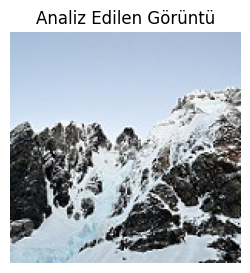


--- Model Katman Aktivasyonları ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 190ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


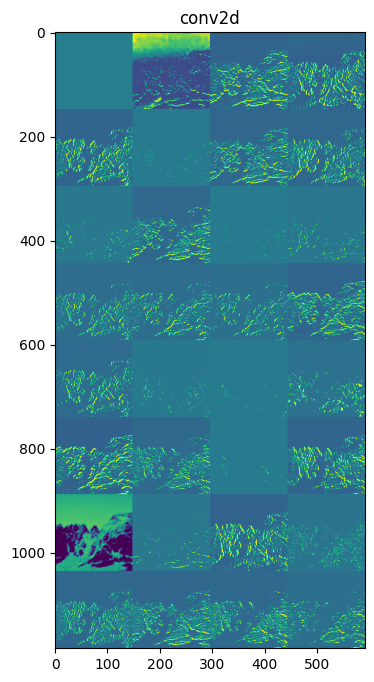

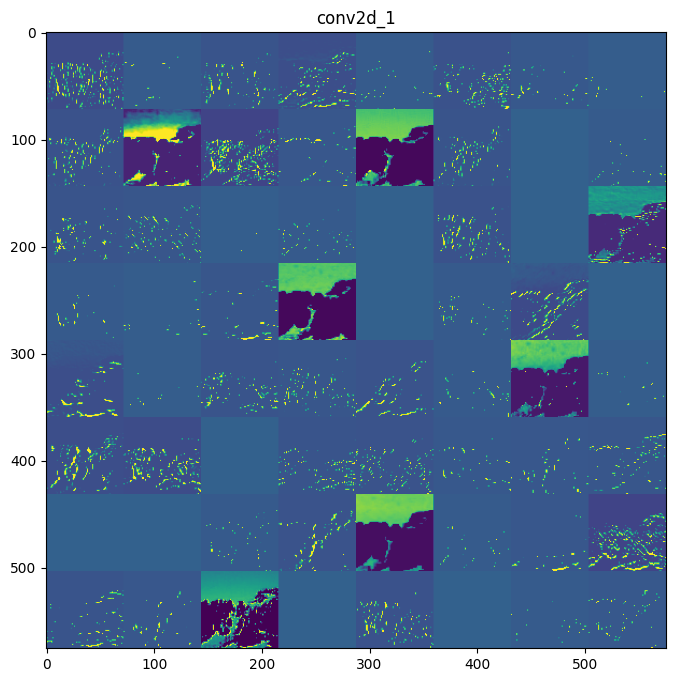

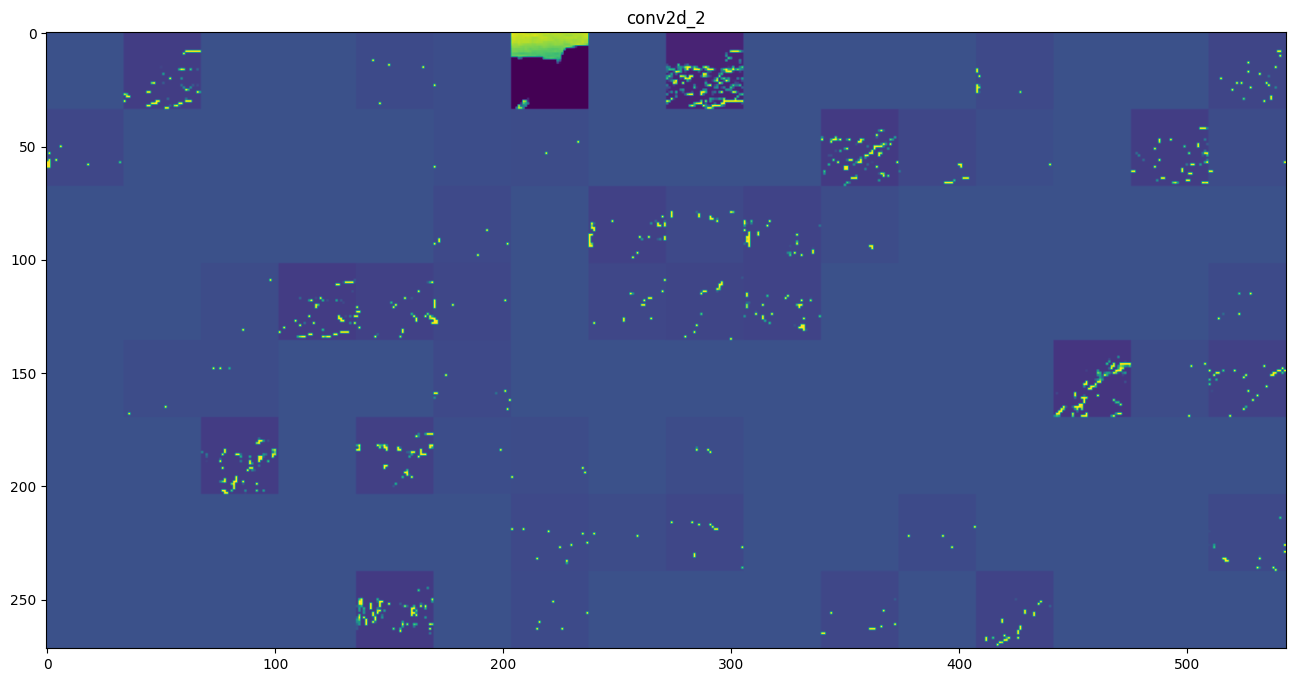

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1. ADIM: GEREKLİ ORTAMI HAZIRLA
print("Değerlendirme için gerekli ortam hazırlanıyor...")
IMG_HEIGHT = 150
IMG_WIDTH = 150
test_dir = '../input/intel-image-classification/seg_test/seg_test'

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=1,
    class_mode='sparse',
    shuffle=True
)

model = load_model('/kaggle/input/akbank-dataset/akbank_model_son.keras')
print("Ortam hazırlandı. Aktivasyon haritaları oluşturuluyor...")



img_tensor, _ = next(validation_generator)


plt.figure(figsize=(3,3))
plt.title("Analiz Edilen Görüntü")
plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

print("\n--- Model Katman Aktivasyonları ---")

for i, layer in enumerate(model.layers):
    if 'conv' not in layer.name:
        continue


    temp_model = Sequential(model.layers[:i+1])
    
    
    activations = temp_model.predict(img_tensor)
    
    
    n_features = activations.shape[-1]
    size = activations.shape[1]
    
    n_cols = max(n_features // 8, 1)
    n_rows = (n_features + n_cols - 1) // n_cols
    
    display_grid = np.zeros((size * n_rows, n_cols * size))
    
    for j in range(n_features):
        col = j % n_cols
        row = j // n_cols
        
        channel_image = activations[0, :, :, j]
        channel_image -= channel_image.mean()
        if channel_image.std() > 0:
            channel_image /= channel_image.std()
        channel_image *= 64
        channel_image += 128
        channel_image = np.clip(channel_image, 0, 255).astype('uint8')
        display_grid[row * size : (row + 1) * size,
                     col * size : (col + 1) * size] = channel_image
                         
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer.name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

### 5.3. Modelin Yorumlanması: Grad-CAM ile Isı Haritası Görselleştirmesi

Modelimizin sayısal metriklerdeki başarısını gördükten sonra, projenin en önemli adımlarından biri olan **yorumlama** kısmına geçiyoruz. Bu aşamada, modelimizin bir görüntüye bakarak karar verirken, o görüntünün hangi bölgelerine "odaklandığını" görselleştireceğiz. Bu, "kara kutu" olarak görülen derin öğrenme modellerinin karar mekanizmalarını daha şeffaf hale getirmek için kullanılır ve proje dosyasındaki temel gereksinimlerden biridir.

Aşağıdaki kod, bu işlemi **Grad-CAM** (Gradient-weighted Class Activation Mapping) tekniğini kullanarak gerçekleştirir.

#### Fonksiyonların Açıklaması

* **`get_grad_cam_heatmap` Fonksiyonu:** Bu, Grad-CAM algoritmasının çekirdeğini oluşturan fonksiyondur. Belirli bir görüntü için modelin tahminini alır ve bu tahmin için en etkili olan son konvolüsyon katmanındaki "nöron aktivasyonlarının" gradyanlarını (eğimlerini) hesaplar. Sonuç olarak, modelin kararı için hangi piksellerin en önemli olduğunu gösteren bir **ısı haritası (heatmap)** üretir.

* **`overlay_heatmap` Fonksiyonu:** Bu yardımcı fonksiyon, `get_grad_cam_heatmap` tarafından üretilen ham ısı haritasını alır, renklendirir (`JET` renk haritası ile) ve yarı şeffaf bir şekilde orijinal görüntünün üzerine bindirir.

Yukarıdaki kod bu iki fonksiyonu tanımlar, test setinden bir görüntü üzerinde çalıştırır ve modelin "gözünden" o görüntünün neye benzediğini bize gösterir. Kırmızı bölgeler, modelin karar verirken en çok odaklandığı alanlardır.